## Setup enviroment

In [1]:
import os
import gc
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss
import joblib
from venn_abers import VennAbersCalibrator
import sys
sys.path.append(r'C:\Users\jeanr\Documents\projetos\classificacao\lending-club\global')
from util import *
import json

c:\Users\jeanr\Documents\projetos\classificacao\lending-club\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the calibration data

In [2]:
train_df = pd.read_parquet('../data/processed/abt_train.parquet')
validation_df = pd.read_parquet('../data/processed/abt_validation.parquet')
calibration_df = pd.read_parquet('../data/processed/abt_calibration.parquet')

In [3]:
categorical_column_names = train_df.select_dtypes(include=['category']).columns
categorical_column_names

Index(['grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'application_type'],
      dtype='object')

In [4]:
cat_features = ['grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'application_type']

In [5]:

target = 'default'

# Input variables and Target dataframes
X_train, y_train= train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (354976, 99) (354976,)
Validation shape:  (264688, 99) (264688,)
Calibration shape:  (66173, 99) (66173,)


## Loading models

In [6]:
# Base model
# Load the baseline and feature selection models
baseline_model_path = '../artifacts/baseline_model.joblib'
feat_selection_model_path = '../artifacts/feat_selection_model.joblib'
tunned_model_path = '../artifacts/tunned_model.joblib'

baseline_model = joblib.load(baseline_model_path)
feat_selection_model = joblib.load(feat_selection_model_path)
tunned_model = joblib.load(tunned_model_path) 

champion_model = feat_selection_model

In [7]:
selected_features = None
with open('../artifacts/selected_features_list.json', 'r') as f:
    selected_features = json.load(f)
print(selected_features)

['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_record', 'revol_bal', 'total_acc', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_il_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit', 'income_to_loan_ratio', 'debt_to_income_ratio', 'loan_amnt_per_income', 'fico_avg', 'credit_utilization_ratio', 'delinquency_ratio', 'int_rate_to_income_ratio', 'public_records_impact', 'pct_active_bc', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'application_type']


## Calibrate the model using Platt scaling (sigmoid) and isotonic regression

In [8]:
# Platt scaling (sigmoid)
print('Fitting platt scaling calibration...')
calibrated_model_sigmoid = CalibratedClassifierCV(champion_model, method='sigmoid')
calibrated_model_sigmoid.fit(X_calibration[selected_features], y_calibration)
y_pred_sigmoid = calibrated_model_sigmoid.predict_proba(X_validation[selected_features])[:, 1]

Fitting platt scaling calibration...
0:	learn: 0.3502373	total: 198ms	remaining: 3m 17s
1:	learn: 0.3611671	total: 272ms	remaining: 2m 15s
2:	learn: 0.3633952	total: 347ms	remaining: 1m 55s
3:	learn: 0.3686409	total: 421ms	remaining: 1m 44s
4:	learn: 0.3711250	total: 496ms	remaining: 1m 38s
5:	learn: 0.3729150	total: 567ms	remaining: 1m 33s
6:	learn: 0.3732246	total: 633ms	remaining: 1m 29s
7:	learn: 0.3744084	total: 716ms	remaining: 1m 28s
8:	learn: 0.3745334	total: 801ms	remaining: 1m 28s
9:	learn: 0.3742044	total: 872ms	remaining: 1m 26s
10:	learn: 0.3739259	total: 951ms	remaining: 1m 25s
11:	learn: 0.3738836	total: 1.03s	remaining: 1m 24s
12:	learn: 0.3745997	total: 1.11s	remaining: 1m 24s
13:	learn: 0.3747475	total: 1.19s	remaining: 1m 23s
14:	learn: 0.3752177	total: 1.27s	remaining: 1m 23s
15:	learn: 0.3756440	total: 1.35s	remaining: 1m 23s
16:	learn: 0.3755988	total: 1.43s	remaining: 1m 22s
17:	learn: 0.3758746	total: 1.52s	remaining: 1m 22s
18:	learn: 0.3761744	total: 1.6s	rema

In [17]:
# Compute metrics for Platt scaling and isotonic regression
print("Platt Scaling (Sigmoid) Metrics:")
clf_metric_report(y_pred_sigmoid, y_validation)

Platt Scaling (Sigmoid) Metrics:
Evaluating the model...
ROC AUC: 0.7111368826126401
Brier Score: 0.14464134911876522
Average Precision: 0.3751997535633947
Log Loss: 0.45298327077737505


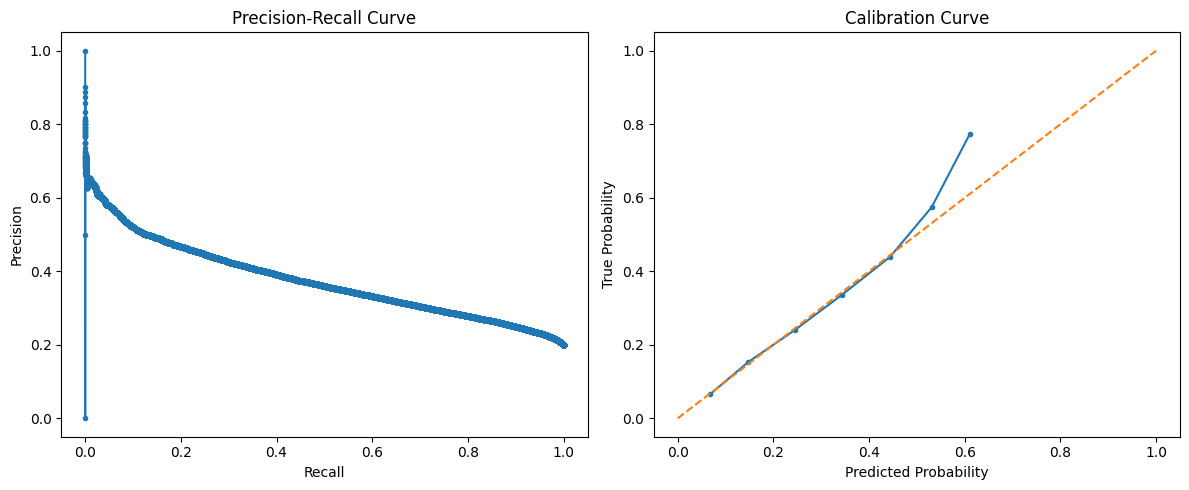

In [10]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_sigmoid, y_validation)

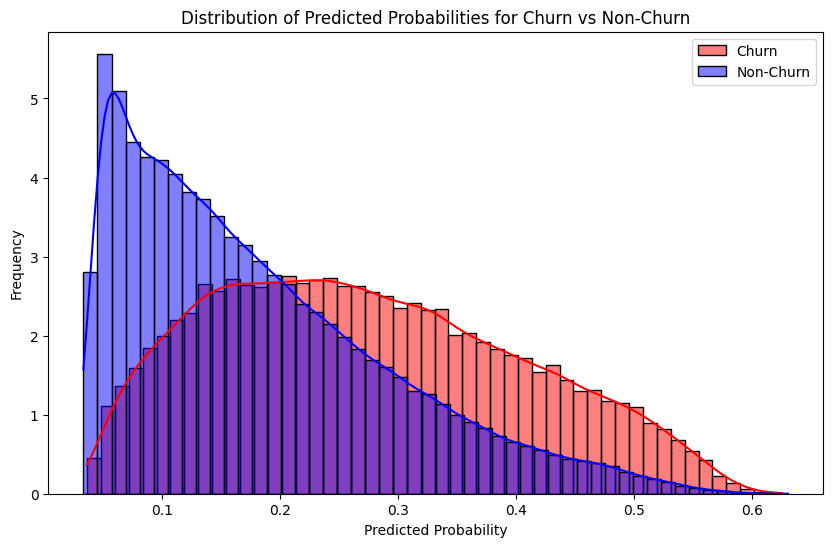

In [11]:
plot_dis_probs(y_pred_sigmoid, y_validation)

## Calibrate the model using Venn-Abers

In [15]:
p_cal = tunned_model.predict_proba(X_calibration[selected_features])
p_test = tunned_model.predict_proba(X_validation[selected_features])

va = VennAbersCalibrator()
va_prefit_prob = va.predict_proba(p_cal=p_cal, y_cal=y_calibration.values, p_test=p_test)
y_pred_va = va_prefit_prob[:, 1]

c:\Users\jeanr\Documents\projetos\classificacao\lending-club\.venv\Lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


In [16]:
# Compute metrics for Venn-Abers calibration
print("\nVenn-Abers Calibration Metrics:")
clf_metric_report(y_pred_va, y_validation)


Venn-Abers Calibration Metrics:
Evaluating the model...
ROC AUC: 0.7127784258414971
Brier Score: 0.14437287613683614
Average Precision: 0.3702612648220308
Log Loss: 0.45198063919545556


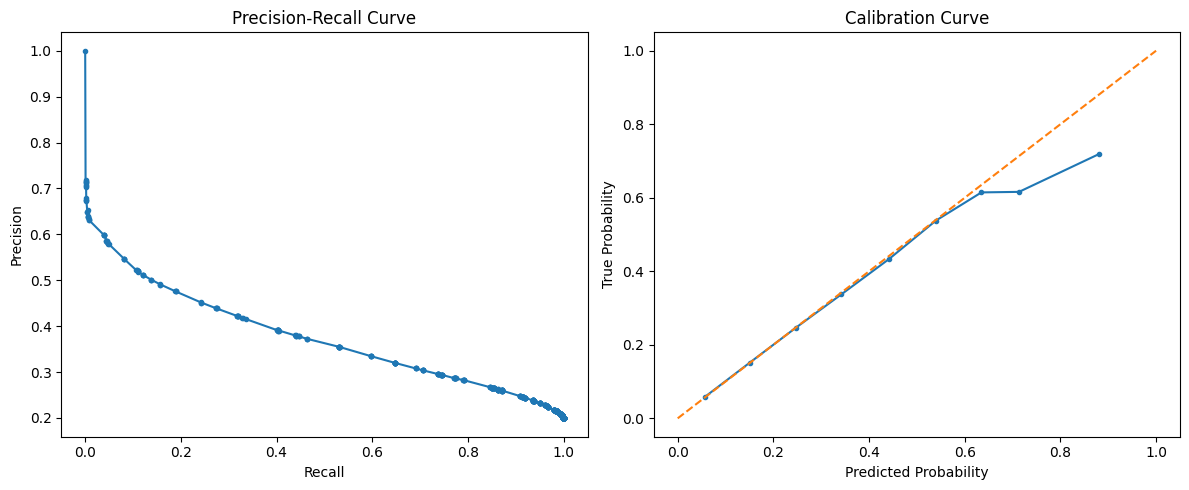

In [18]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_va, y_validation)

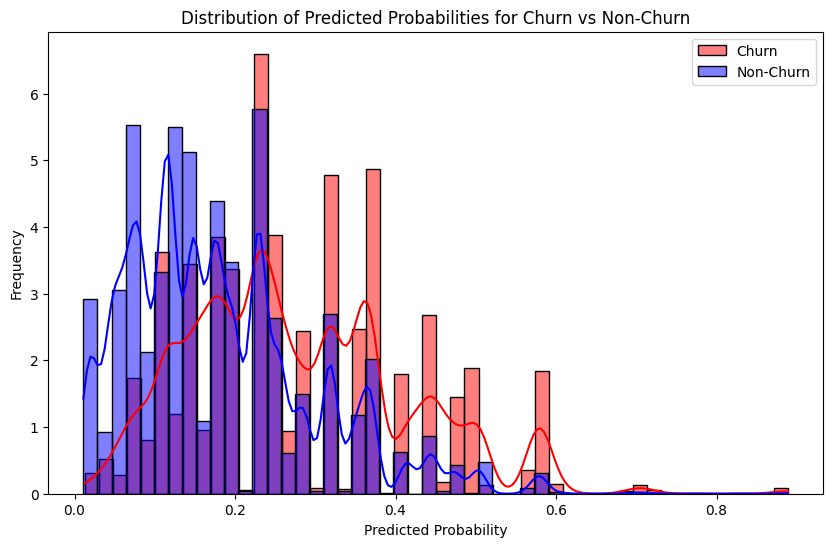

In [19]:
plot_dis_probs(y_pred_va, y_validation)

## Compare the models

In [21]:
# Predict using the baseline model
y_pred_baseline = baseline_model.predict_proba(X_validation)[:, 1]

# Predict using the feature selection model
y_pred_feat_selection = feat_selection_model.predict_proba(X_validation[selected_features])[:, 1]

# Predict using the tunned model
y_pred_tunned= tunned_model.predict_proba(X_validation[selected_features])[:, 1]

# Compare the models using clf_metric_report
print("Baseline Model Metrics:")
clf_metric_report(y_pred_baseline, y_validation)

print("\nFeature Selection Model Metrics:")
clf_metric_report(y_pred_feat_selection, y_validation)

print("\nTuned Model Metrics:")
clf_metric_report(y_pred_tunned, y_validation)

print("\nChampion Platt Scaling (Sigmoid) Metrics:")
clf_metric_report(y_pred_sigmoid, y_validation)

print("\nnChampion Venn-Abers Calibration Metrics:")
clf_metric_report(y_pred_va, y_validation)


Baseline Model Metrics:
Evaluating the model...
ROC AUC: 0.7136125466318978
Brier Score: 0.22243166224662975
Average Precision: 0.37747797214444334
Log Loss: 0.6318950887273754

Feature Selection Model Metrics:
Evaluating the model...
ROC AUC: 0.7145947006124027
Brier Score: 0.20841774246499378
Average Precision: 0.37845764985249675
Log Loss: 0.6008338850055344

Tuned Model Metrics:
Evaluating the model...
ROC AUC: 0.7130042713689885
Brier Score: 0.20830469508140884
Average Precision: 0.3771536041046522
Log Loss: 0.6004214725099031

Champion Platt Scaling (Sigmoid) Metrics:
Evaluating the model...
ROC AUC: 0.7111368826126401
Brier Score: 0.14464134911876522
Average Precision: 0.3751997535633947
Log Loss: 0.45298327077737505

nChampion Venn-Abers Calibration Metrics:
Evaluating the model...
ROC AUC: 0.7127784258414971
Brier Score: 0.14437287613683614
Average Precision: 0.3702612648220308
Log Loss: 0.45198063919545556


In [22]:
# Caminho para salvar o modelo
model_path = "../artifacts/calibrated_model_sigmoid.pkl"

# Salvando o modelo treinado
joblib.dump(calibrated_model_sigmoid, model_path)

print(f"Modelo salvo em {model_path}")

Modelo salvo em ../artifacts/calibrated_model_sigmoid.pkl
